In [1]:
import torch

# use a GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Set default tensor type to float64
torch.set_default_dtype(torch.float64)

In [2]:
from botorch.utils.sampling import draw_sobol_samples
from botorch.optim import optimize_acqf
import matplotlib.pyplot as plt

In [3]:
seed = 123
# Set the seed for reproducibility
torch.manual_seed(seed)

In [4]:
import torch
import gpytorch
from botorch.models import SingleTaskGP
from gpytorch.likelihoods import FixedNoiseGaussianLikelihood
from gpytorch.means import ConstantMean
from gpytorch.kernels import MaternKernel, ScaleKernel

# Example Usage for 1D
dim = 1

# Define your kernel
nu = 2.5
lengthscale = 0.1
outputscale = 1.0
base_kernel = MaternKernel(nu=nu).double()
base_kernel.lengthscale = torch.tensor([[lengthscale]])
scale_kernel = ScaleKernel(base_kernel).double()
scale_kernel.outputscale = torch.tensor([[outputscale]])

# Define Noise Level
noise_level = 1e-4

# Initialize Placeholder Data with Correct Dimensions
num_samples = 1  # Replace with actual number of samples
num_features = 1  # Replace with actual number of features
train_X = torch.empty(num_samples, num_features)  # Placeholder data
train_Y = torch.empty(num_samples, 1)             # Placeholder data
Yvar = torch.ones(num_samples) * noise_level

# Initialize Model
model = SingleTaskGP(train_X, train_Y, likelihood = FixedNoiseGaussianLikelihood(noise=Yvar), covar_module=scale_kernel)

/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOpt/pandorabayesopt_env/lib/python3.9/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOpt/pandorabayesopt_env/lib/python3.9/site-packages/botorch/models/utils/assorted.py:194: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/ReduceOps.cpp:1760.)
  Ymean, Ystd = torch.mean(Y, dim=-2), torch.std(Y, dim=-2)
/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOpt/pandorabayesopt_env/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.54

In [5]:
from botorch.sampling.pathwise import draw_kernel_feature_paths
matern_sample = draw_kernel_feature_paths(model, sample_shape=torch.Size([1]))
def objective_function(x):
    return matern_sample(x).squeeze(0).detach()

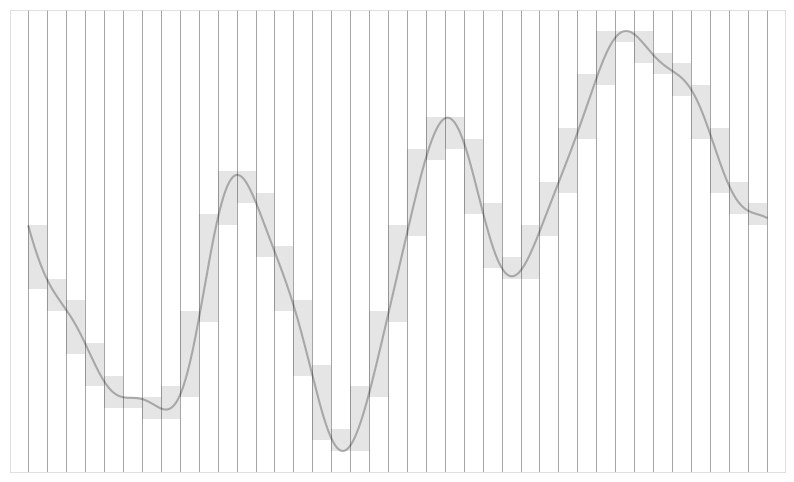

In [15]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# Set global font properties
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'Times New Roman'
plt.rcParams['xtick.labelsize'] = 40
plt.rcParams['ytick.labelsize'] = 40

# Generate test data
test_x = torch.linspace(0, 1, 1001)
y_values = objective_function(test_x.view(-1, 1)).detach().cpu().numpy()

# Plot setup
plt.figure(figsize=(10, 6))
plt.plot(test_x.cpu().numpy(), y_values, color='tab:grey', label="Objective function", alpha=0.6)

# Grid setup
grid_density = 40
x_grid = np.linspace(0, 1, grid_density)
y_grid = np.linspace(min(y_values), max(y_values), grid_density)

# Analyze each grid cell
for i in range(len(x_grid) - 1):
    for j in range(len(y_grid) - 1):
        # Define cell corners
        x0, x1 = x_grid[i], x_grid[i + 1]
        y0, y1 = y_grid[j], y_grid[j + 1]

        # Sample the function within the cell
        x_sample = np.linspace(x0, x1, 10)
        y_sample = objective_function(torch.tensor(x_sample).view(-1, 1)).detach().cpu().numpy()

        # Check if any part of the function is within this cell's y range
        if np.any((y_sample >= y0) & (y_sample <= y1)):
            plt.fill_between([x0, x1], y0, y1, color='grey', alpha=0.2, edgecolor='none')

# Draw vertical grid lines only
for x_line in x_grid:
    plt.axvline(x=x_line, color='black', linestyle='-', linewidth=0.5, alpha=0.5)

# Adjust margins on the x-axis
plt.margins(x=0.025)  # Adjust the margin to be narrower

plt.xticks([])
plt.yticks([])

# Get the current Axes object
ax = plt.gca()

# Customize spines to make them less obvious
ax.spines['top'].set_color('lightgrey')
ax.spines['top'].set_linewidth(0.5)
ax.spines['right'].set_color('lightgrey')
ax.spines['right'].set_linewidth(0.5)
ax.spines['left'].set_color('lightgrey')
ax.spines['left'].set_linewidth(0.5)
ax.spines['bottom'].set_color('lightgrey')
ax.spines['bottom'].set_linewidth(0.5)

plt.savefig('plot/objective_discrete.pdf', format='pdf')
plt.show()

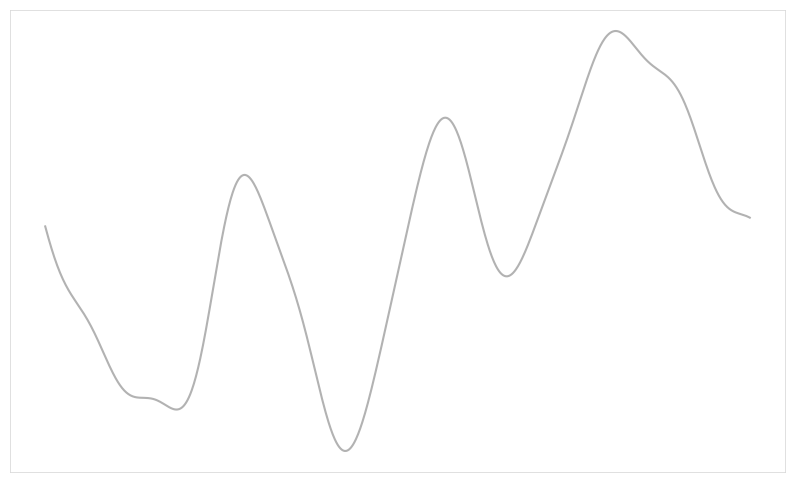

In [16]:
# Plot setup
plt.figure(figsize=(10, 6))
plt.plot(test_x.cpu().numpy(), y_values, color='tab:grey', label="Objective function", alpha=0.6)
plt.xticks([])
plt.yticks([])

# Get the current Axes object
ax = plt.gca()

# Customize spines to make them less obvious
ax.spines['top'].set_color('lightgrey')
ax.spines['top'].set_linewidth(0.5)
ax.spines['right'].set_color('lightgrey')
ax.spines['right'].set_linewidth(0.5)
ax.spines['left'].set_color('lightgrey')
ax.spines['left'].set_linewidth(0.5)
ax.spines['bottom'].set_color('lightgrey')
ax.spines['bottom'].set_linewidth(0.5)

plt.savefig('plot/objective_continuous.pdf', format='pdf')
plt.show()

In [8]:
def plot_posterior(objective_function,model,test_x,train_x,train_y):
    
    with torch.no_grad():
        
        # # Plot the objective function at the test points
        plt.plot(test_x.cpu().numpy(), objective_function(test_x.view(-1,1)).detach().numpy(), 'tab:grey', alpha=0.6)
    
        # Calculate the posterior at the test points
        posterior = model.posterior(test_x.unsqueeze(1).unsqueeze(1))

        # Get upper and lower confidence bounds (2 standard deviations from the mean)
        lower, upper = posterior.mvn.confidence_region()
        lower = lower.squeeze(-1).squeeze(-1)
        upper = upper.squeeze(-1).squeeze(-1)
        # Plot training points as black stars
        plt.plot(train_x.cpu().numpy(), train_y.cpu().numpy(), 'k*', alpha=0.8, markersize=10)
        # Plot posterior means as blue line
        plt.plot(test_x.cpu().numpy(), posterior.mean.squeeze(-1).squeeze(-1).cpu().numpy(), alpha=0.8)
        # Shade between the lower and upper confidence bounds
        plt.fill_between(test_x.cpu().numpy(), lower.cpu().numpy(), upper.cpu().numpy(), alpha=0.2)
        plt.axis("off")
        
    
    # Define legend labels
    legend_labels = ['Objective Function', 'Observed Data', 'Prediction', 'Confidence']
    # Add legend to the axis
    # plt.legend(legend_labels, fontsize=24, loc='lower right')

/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOpt/pandorabayesopt_env/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.0413]), std = tensor([0.7097])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


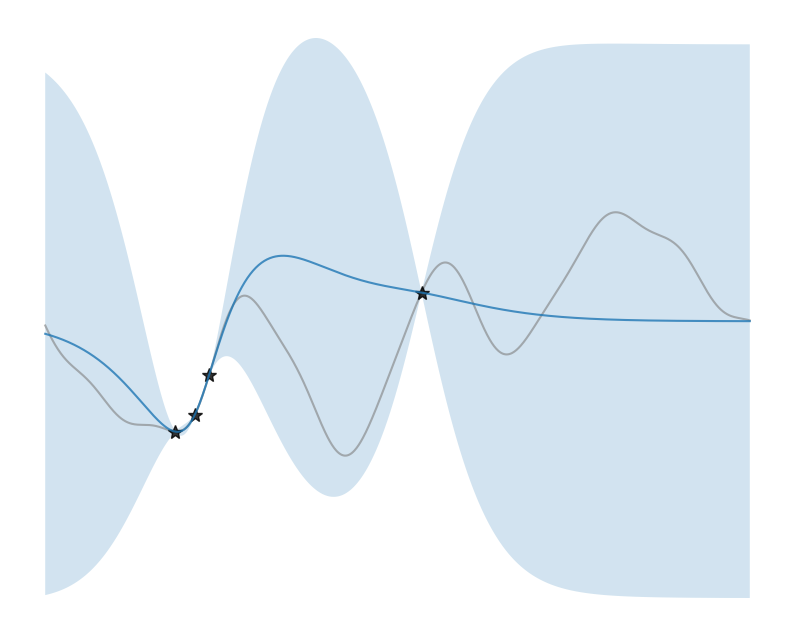

In [9]:
from botorch.utils.sampling import draw_sobol_samples
from pandora_bayesopt.utils import fit_gp_model

plt.rcParams['xtick.labelsize'] = 24
plt.rcParams['ytick.labelsize'] = 24

bounds = torch.stack([torch.zeros(dim), torch.ones(dim)])
init_x = draw_sobol_samples(bounds=bounds, n=1, q=2*(dim+1)).squeeze(0)
x = init_x
y = objective_function(x)
model = fit_gp_model(x, y, scale_kernel)
# Plot the posterior
plt.figure(figsize=(10, 8))
plot_posterior(objective_function,model,test_x,x,y)
plt.axis("off")
plt.savefig('plot/bayesopt.pdf', format='pdf')
plt.show()